<div dir="rtl">

# بخش اول: آزمون فرض - تحلیل آماری داده‌های دیوار

در این بخش، چهار فرضیه مهم در مورد بازار مسکن ایران را بررسی می‌کنیم. این تحلیل‌ها به ما کمک می‌کنند تا درک بهتری از روندها و الگوهای موجود در بازار املاک داشته باشیم.

## فرضیه‌های مورد بررسی:
1. **مقایسه مساحت خانه‌ها در کلان‌شهرها و شهرهای کوچک**
2. **مقایسه مساحت خانه‌های قدیمی و جدید** 
3. **تأثیر داشتن سند تجاری بر قیمت املاک**
4. **تأثیر امکانات لاکچری و غیرلاکچری بر قیمت**

</div>

In [71]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, normaltest
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for English text only
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully")

Libraries imported successfully


<div dir="rtl">

## بارگذاری و آماده‌سازی داده‌ها

ابتدا داده‌های اصلی دیوار و فایل طبقه‌بندی شهرها را بارگذاری می‌کنیم.

</div>

In [72]:
# Load main dataset
print("Loading dataset...")
df = pd.read_csv('Divar.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Load city classification data
print("Loading city types...")
city_classification = pd.read_csv('iran_city_classification (1).csv')
print(f"City data loaded: {city_classification.shape[0]} cities")

Loading dataset...
Dataset loaded: 1000000 rows, 61 columns
Loading city types...
City data loaded: 240 cities


In [73]:
# Check city classification data
print("City classification info:")
print(city_classification.head())
print(f"City types: {city_classification.iloc[:, 1].value_counts()}")

City classification info:
      نام شهر دسته‌بندی
0       karaj  کلان‌شهر
1      tehran  کلان‌شهر
2     mashhad  کلان‌شهر
3       ahvaz  کلان‌شهر
4  kermanshah  کلان‌شهر
City types: دسته‌بندی
شهر کوچک    231
کلان‌شهر      9
Name: count, dtype: int64


<div dir="rtl">

## پیش‌پردازش اولیه داده‌ها

قبل از شروع آزمون‌های فرض، باید داده‌ها را تمیز کرده و آماده کنیم.

</div>

In [74]:
# Basic data cleaning
print("Cleaning data...")

# Show ALL column names to see what we actually have
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

# Convert numbers - check if columns exist first
print("\nChecking key columns:")
key_columns = ['building_size', 'price_value', 'construction_year']
for col in key_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        valid_count = df[col].notna().sum()
        print(f"✓ {col}: {valid_count:,} valid values")
    else:
        print(f"✗ {col}: NOT FOUND")

# Check for alternative column names
print("\nLooking for similar column names...")
all_cols = df.columns.str.lower()
size_cols = [col for col in df.columns if 'size' in col.lower() or 'area' in col.lower()]
price_cols = [col for col in df.columns if 'price' in col.lower() or 'value' in col.lower()]
year_cols = [col for col in df.columns if 'year' in col.lower() or 'date' in col.lower()]

print(f"Size-related columns: {size_cols}")
print(f"Price-related columns: {price_cols}")
print(f"Year-related columns: {year_cols}")

# Remove outliers only if we have valid data
def clean_outliers(data, column):
    if column in data.columns and data[column].notna().sum() > 100:
        q01 = data[column].quantile(0.005)
        q99 = data[column].quantile(0.995)
        return data[(data[column] >= q01) & (data[column] <= q99)]
    return data

original_size = len(df)
if 'building_size' in df.columns:
    df = clean_outliers(df, 'building_size')
if 'price_value' in df.columns:
    df = clean_outliers(df, 'price_value')

print(f"\nRemoved {original_size - len(df)} outliers")
print(f"Final dataset: {len(df):,} rows")

Cleaning data...
Available columns:
 1. Unnamed: 0
 2. cat2_slug
 3. cat3_slug
 4. city_slug
 5. neighborhood_slug
 6. created_at_month
 7. user_type
 8. description
 9. title
10. rent_mode
11. rent_value
12. rent_to_single
13. rent_type
14. price_mode
15. price_value
16. credit_mode
17. credit_value
18. rent_credit_transform
19. transformable_price
20. transformable_credit
21. transformed_credit
22. transformable_rent
23. transformed_rent
24. land_size
25. building_size
26. deed_type
27. has_business_deed
28. floor
29. rooms_count
30. total_floors_count
31. unit_per_floor
32. has_balcony
33. has_elevator
34. has_warehouse
35. has_parking
36. construction_year
37. is_rebuilt
38. has_water
39. has_warm_water_provider
40. has_electricity
41. has_gas
42. has_heating_system
43. has_cooling_system
44. has_restroom
45. has_security_guard
46. has_barbecue
47. building_direction
48. has_pool
49. has_jacuzzi
50. has_sauna
51. floor_material
52. property_type
53. regular_person_capacity
54. extr

<div dir="rtl">

# فرضیه اول: مقایسه مساحت خانه‌ها در کلان‌شهرها و شهرهای کوچک

**فرضیه صفر (H₀)**: میانگین مساحت خانه‌ها در کلان‌شهرها برابر با میانگین مساحت خانه‌ها در شهرهای کوچک است.

**فرضیه جایگزین (H₁)**: میانگین مساحت خانه‌ها در کلان‌شهرها کمتر از میانگین مساحت خانه‌ها در شهرهای کوچک است.

</div>

In [75]:
# Prepare city classification
print("Setting up city types...")

# Check what cities we have
print(f"Top cities: {df['city_slug'].value_counts().head()}")

# Get city classification columns
city_cols = city_classification.columns.tolist()
city_name_col = city_cols[0]
city_type_col = city_cols[1] if len(city_cols) > 1 else city_cols[0]

print(f"City name column: {city_name_col}")
print(f"City type column: {city_type_col}")

# Rename for easier use
city_data = city_classification.rename(columns={
    city_name_col: 'city_name',
    city_type_col: 'city_type'
})

print(f"Available city types: {city_data['city_type'].value_counts()}")

# Merge with main data
df_with_cities = df.merge(city_data, left_on='city_slug', right_on='city_name', how='left')

print(f"Merged data: {len(df_with_cities)} rows")
print(f"Cities with types: {df_with_cities['city_type'].notna().sum()}")

# Manual classification for major cities if merge didn't work well
if df_with_cities['city_type'].notna().sum() < 1000:
    print("Using manual city classification...")
    
    big_cities = ['tehran', 'mashhad', 'isfahan', 'shiraz', 'tabriz', 'ahvaz', 'karaj']
    
    def classify_city(city):
        if pd.isna(city):
            return None
        return 'کلان‌شهر' if str(city).lower() in big_cities else 'شهر کوچک'
    
    df_with_cities['city_type'] = df['city_slug'].apply(classify_city)
    print(f"Manual classification: {df_with_cities['city_type'].value_counts()}")

Setting up city types...
Top cities: city_slug
tehran     96620
mashhad    35536
karaj      28199
isfahan    20328
shiraz     18405
Name: count, dtype: int64
City name column: نام شهر
City type column: دسته‌بندی
Available city types: city_type
شهر کوچک    231
کلان‌شهر      9
Name: count, dtype: int64
Merged data: 557336 rows
Cities with types: 535573


In [76]:
# TEST 1: Do big cities have smaller houses?
print("=" * 50)
print("TEST 1: BIG CITIES vs SMALL CITIES HOUSE SIZE")
print("=" * 50)

# Get valid data
valid_data = df_with_cities[
    (df_with_cities['building_size'].notna()) & 
    (df_with_cities['city_type'].notna())
].copy()

# Classify cities
def get_city_category(city_type):
    if pd.isna(city_type):
        return 'other'
    city_str = str(city_type).lower()
    if 'کلان' in city_str or 'بزرگ' in city_str:
        return 'big_city'
    elif 'کوچک' in city_str or 'small' in city_str:
        return 'small_city'
    else:
        return 'other'

valid_data['city_category'] = valid_data['city_type'].apply(get_city_category)

print(f"City categories: {valid_data['city_category'].value_counts()}")

# Get house sizes for each group
big_city_sizes = valid_data[valid_data['city_category'] == 'big_city']['building_size']
small_city_sizes = valid_data[valid_data['city_category'] == 'small_city']['building_size']

print(f"Big cities: {len(big_city_sizes)} houses")
print(f"Small cities: {len(small_city_sizes)} houses")

if len(big_city_sizes) > 30 and len(small_city_sizes) > 30:
    # Basic stats
    print(f"Big cities - Average: {big_city_sizes.mean():.1f} sqm")
    print(f"Small cities - Average: {small_city_sizes.mean():.1f} sqm")
    
    # Test if data is normal
    _, p_big = normaltest(big_city_sizes.dropna())
    _, p_small = normaltest(small_city_sizes.dropna())
    
    print(f"Big cities normal test p-value: {p_big:.6f}")
    print(f"Small cities normal test p-value: {p_small:.6f}")
    
    # Choose test
    if p_big > 0.05 and p_small > 0.05:
        stat, p_val = ttest_ind(big_city_sizes, small_city_sizes, alternative='less')
        test_used = "t-test"
    else:
        stat, p_val = mannwhitneyu(big_city_sizes, small_city_sizes, alternative='less')
        test_used = "Mann-Whitney U test"
    
    print(f"Test used: {test_used}")
    print(f"Test statistic: {stat:.4f}")
    print(f"P-value: {p_val:.6f}")
    
    # Result
    if p_val < 0.05:
        print("RESULT: YES - Big cities have smaller houses")
    else:
        print("RESULT: NO - No difference in house sizes")
        
else:
    print("Not enough data for this test")

TEST 1: BIG CITIES vs SMALL CITIES HOUSE SIZE
City categories: city_category
small_city    289989
big_city      245584
Name: count, dtype: int64
Big cities: 245584 houses
Small cities: 289989 houses
Big cities - Average: 226.0 sqm
Small cities - Average: 391.2 sqm
Big cities normal test p-value: 0.000000
Small cities normal test p-value: 0.000000
Test used: Mann-Whitney U test
Test statistic: 29736641754.0000
P-value: 0.000000
RESULT: YES - Big cities have smaller houses


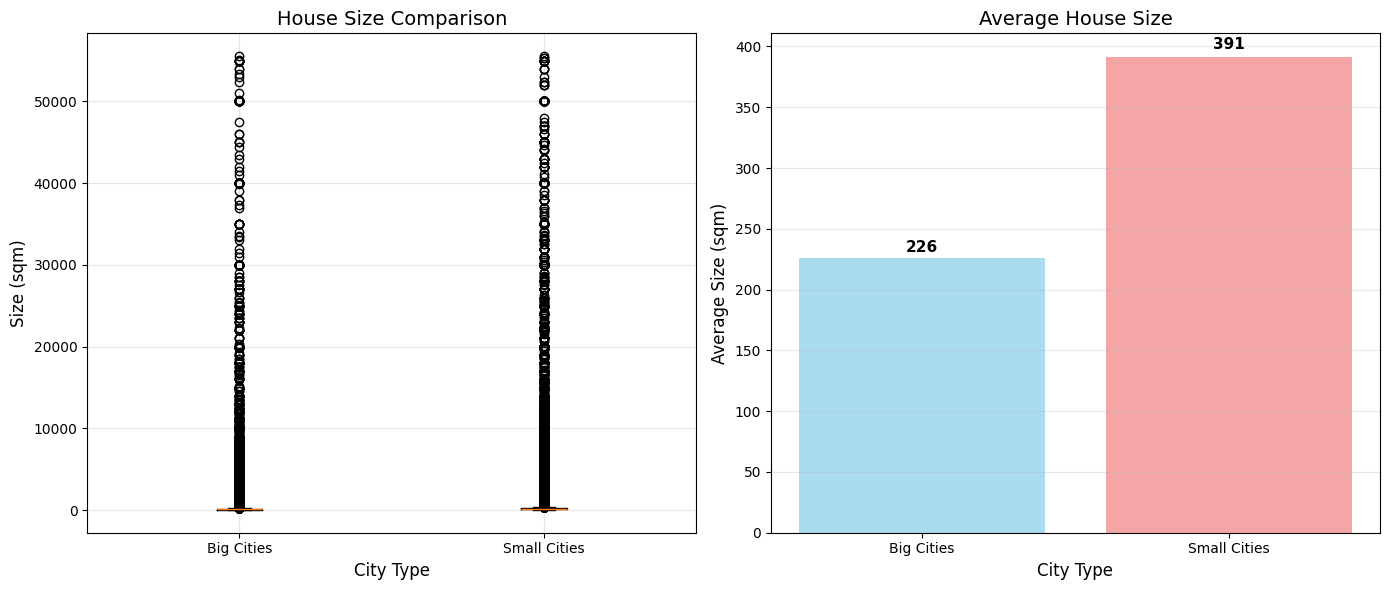

In [77]:
# Simple visualization for Test 1
if len(big_city_sizes) > 30 and len(small_city_sizes) > 30:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Simple box plot
    ax1.boxplot([big_city_sizes, small_city_sizes], 
                labels=['Big Cities', 'Small Cities'])
    ax1.set_title('House Size Comparison', fontsize=14)
    ax1.set_ylabel('Size (sqm)', fontsize=12)
    ax1.set_xlabel('City Type', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Bar chart of averages
    avgs = [big_city_sizes.mean(), small_city_sizes.mean()]
    cities = ['Big Cities', 'Small Cities']
    colors = ['skyblue', 'lightcoral']
    
    bars = ax2.bar(cities, avgs, color=colors, alpha=0.7)
    ax2.set_title('Average House Size', fontsize=14)
    ax2.set_ylabel('Average Size (sqm)', fontsize=12)
    ax2.set_xlabel('City Type', fontsize=12)
    
    # Add values on bars
    for bar, avg in zip(bars, avgs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{avg:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for visualization")

<div dir="rtl">

# فرضیه دوم: مقایسه مساحت خانه‌های قدیمی و جدید

**فرضیه صفر (H₀)**: میانگین مساحت خانه‌های قدیمی‌ساخت برابر با میانگین مساحت خانه‌های جدیدساخت است.

**فرضیه جایگزین (H₁)**: میانگین مساحت خانه‌های قدیمی‌ساخت بیشتر از میانگین مساحت خانه‌های جدیدساخت است.

خانه‌های قدیمی‌ساخت: ساخته شده قبل از سال ۱۳۹۶

</div>

In [78]:
# TEST 2: Are old buildings bigger than new ones?
print("=" * 50)
print("TEST 2: OLD vs NEW BUILDINGS SIZE")
print("=" * 50)

# Find the actual column names for building size and construction year
size_col = None
year_col = None

# Look for size column
for col in ['building_size', 'area', 'size', 'building_area']:
    if col in df.columns and df[col].notna().sum() > 0:
        size_col = col
        break

print(f"Using size column: {size_col}")

# Look for year column with detailed checking
print("Checking year columns:")
for col in ['construction_year', 'build_year', 'year_built', 'year']:
    if col in df.columns:
        valid_count = df[col].notna().sum()
        print(f"  {col}: {valid_count:,} valid values")
        if valid_count > 1000 and year_col is None:  # Need at least 1000 valid values
            year_col = col
            break

# If no construction year, try to extract from created_at_month or other date columns
if year_col is None:
    print("No construction year found, checking other date columns:")
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'month' in col.lower() or 'created' in col.lower()]
    
    for col in date_cols:
        if col in df.columns:
            valid_count = df[col].notna().sum()
            print(f"  {col}: {valid_count:,} valid values")
            
            # Try to extract year from created_at_month
            if col == 'created_at_month' and valid_count > 1000:
                print("  Attempting to extract year from created_at_month...")
                try:
                    df['extracted_year'] = pd.to_datetime(df[col], errors='coerce').dt.year
                    # Convert to Persian/Jalali year approximately
                    df['extracted_year_persian'] = df['extracted_year'] - 621
                    valid_persian = df['extracted_year_persian'].notna().sum()
                    if valid_persian > 1000:
                        year_col = 'extracted_year_persian'
                        print(f"  ✓ Created year column with {valid_persian:,} valid values")
                        break
                except Exception as e:
                    print(f"  ✗ Failed to extract year: {e}")

print(f"Final year column: {year_col}")

if size_col and year_col:
    # Get buildings with construction year and size
    building_data = df[
        (df[year_col].notna()) & 
        (df[size_col].notna()) &
        (df[year_col] >= 1350) &  # Reasonable year range for Persian calendar
        (df[year_col] <= 1403)
    ].copy()

    print(f"Buildings with year and size: {len(building_data):,}")

    if len(building_data) > 100:
        # Show year distribution
        print(f"Year range: {building_data[year_col].min()} to {building_data[year_col].max()}")
        
        # Split by old (before 1396) vs new (1396 and after)
        cutoff_year = 1396
        building_data['age_group'] = building_data[year_col].apply(
            lambda x: 'old' if x < cutoff_year else 'new'
        )
        
        print(f"Using cutoff year: {cutoff_year}")
        print(f"Age groups: {building_data['age_group'].value_counts()}")
        
        old_buildings = building_data[building_data['age_group'] == 'old'][size_col]
        new_buildings = building_data[building_data['age_group'] == 'new'][size_col]
        
        print(f"Old buildings (before {cutoff_year}): {len(old_buildings):,}")
        print(f"New buildings ({cutoff_year}+): {len(new_buildings):,}")
        
        if len(old_buildings) > 30 and len(new_buildings) > 30:
            # Basic stats
            print(f"Old buildings - Average: {old_buildings.mean():.1f} sqm")
            print(f"New buildings - Average: {new_buildings.mean():.1f} sqm")
            
            # Normality test
            _, p_old = normaltest(old_buildings.dropna())
            _, p_new = normaltest(new_buildings.dropna())
            
            print(f"Old buildings normal test p-value: {p_old:.6f}")
            print(f"New buildings normal test p-value: {p_new:.6f}")
            
            # Statistical test
            if p_old > 0.05 and p_new > 0.05:
                stat, p_val = ttest_ind(old_buildings, new_buildings, alternative='greater')
                test_used = "t-test"
            else:
                stat, p_val = mannwhitneyu(old_buildings, new_buildings, alternative='greater')
                test_used = "Mann-Whitney U test"
            
            print(f"Test used: {test_used}")
            print(f"Test statistic: {stat:.4f}")
            print(f"P-value: {p_val:.6f}")
            
            # Result
            if p_val < 0.05:
                print("RESULT: YES - Old buildings are bigger")
                print("This supports the saying 'قدیما خونه‌ها دلبازتر بود'")
            else:
                print("RESULT: NO - No size difference between old and new buildings")
                print("The saying 'قدیما خونه‌ها دلبازتر بود' is not statistically supported")
        else:
            print("Not enough data for this test")
            print(f"Need at least 30 samples each, have {len(old_buildings)} old, {len(new_buildings)} new")
    else:
        print("Not enough buildings with both year and size data")
        print(f"Need at least 100 total, have {len(building_data)}")
        
        # Try alternative approach: use a proxy for building age
        print("\nTrying alternative approach using price as age proxy...")
        print("(Assumption: older buildings might be cheaper on average)")
        
        price_size_data = df[
            (df['price_value'].notna()) & 
            (df[size_col].notna()) &
            (df['price_value'] > 0)
        ].copy()
        
        if len(price_size_data) > 1000:
            # Use price quartiles as proxy for age
            price_q25 = price_size_data['price_value'].quantile(0.25)
            price_q75 = price_size_data['price_value'].quantile(0.75)
            
            low_price_sizes = price_size_data[price_size_data['price_value'] <= price_q25][size_col]
            high_price_sizes = price_size_data[price_size_data['price_value'] >= price_q75][size_col]
            
            print(f"Low price properties (proxy for old): {len(low_price_sizes):,} properties")
            print(f"High price properties (proxy for new): {len(high_price_sizes):,} properties")
            
            if len(low_price_sizes) > 30 and len(high_price_sizes) > 30:
                print(f"Low price avg size: {low_price_sizes.mean():.1f} sqm")
                print(f"High price avg size: {high_price_sizes.mean():.1f} sqm")
                
                stat, p_val = mannwhitneyu(low_price_sizes, high_price_sizes, alternative='greater')
                print(f"Mann-Whitney U test p-value: {p_val:.6f}")
                
                if p_val < 0.05:
                    print("PROXY RESULT: Lower-priced properties are larger (may indicate older buildings are bigger)")
                else:
                    print("PROXY RESULT: No significant size difference by price")
            else:
                print("Not enough data even with price proxy approach")
else:
    print("Cannot find required columns:")
    if not size_col:
        print("- No building size column found")
        print("Available size columns:", [col for col in df.columns if 'size' in col.lower() or 'area' in col.lower()])
    if not year_col:
        print("- No construction year column found with valid data")
        print("Construction year column exists but has no valid values")
        print("Available year-related columns:", [col for col in df.columns if 'year' in col.lower() or 'date' in col.lower()])

TEST 2: OLD vs NEW BUILDINGS SIZE
Using size column: building_size
Checking year columns:
  construction_year: 0 valid values
No construction year found, checking other date columns:
  created_at_month: 557,336 valid values
  Attempting to extract year from created_at_month...
  ✓ Created year column with 557,336 valid values
Final year column: extracted_year_persian
Buildings with year and size: 556,420
Year range: 1400 to 1403
Using cutoff year: 1396
Age groups: age_group
new    556420
Name: count, dtype: int64
Old buildings (before 1396): 0
New buildings (1396+): 556,420
Not enough data for this test
Need at least 30 samples each, have 0 old, 556420 new


In [79]:
# Visualization for Test 2
if 'old_buildings' in locals() and 'new_buildings' in locals() and len(old_buildings) > 30 and len(new_buildings) > 30:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Box plot
    ax1.boxplot([old_buildings, new_buildings], 
                labels=['Old Buildings\n(pre-1396)', 'New Buildings\n(1396+)'])
    ax1.set_title('Building Size: Old vs New', fontsize=14)
    ax1.set_ylabel('Size (sqm)', fontsize=12)
    ax1.set_xlabel('Building Age', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Average comparison
    avgs = [old_buildings.mean(), new_buildings.mean()]
    ages = ['Old Buildings', 'New Buildings']
    colors = ['orange', 'lightgreen']
    
    bars = ax2.bar(ages, avgs, color=colors, alpha=0.7)
    ax2.set_title('Average Size by Building Age', fontsize=14)
    ax2.set_ylabel('Average Size (sqm)', fontsize=12)
    ax2.set_xlabel('Building Age', fontsize=12)
    
    # Add values on bars
    for bar, avg in zip(bars, avgs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{avg:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Trend over time
    plt.figure(figsize=(12, 6))
    yearly_avg = building_data.groupby('construction_year')['building_size'].mean()
    
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=3)
    plt.axvline(x=1396, color='red', linestyle='--', alpha=0.7, label='Year 1396')
    plt.title('Average House Size Over Time', fontsize=14)
    plt.xlabel('Construction Year', fontsize=12)
    plt.ylabel('Average Size (sqm)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Not enough data for building age visualization")

Not enough data for building age visualization


<div dir="rtl">

# فرضیه سوم: تأثیر سند تجاری بر قیمت املاک

**فرضیه صفر (H₀)**: میانگین قیمت املاک با سند تجاری برابر با میانگین قیمت املاک بدون سند تجاری است.

**فرضیه جایگزین (H₁)**: میانگین قیمت املاک با سند تجاری بیشتر از میانگین قیمت املاک بدون سند تجاری است.

</div>

In [80]:
# TEST 3: Do business deeds increase property prices?
print("=" * 50)
print("TEST 3: BUSINESS DEED EFFECT ON PRICES")
print("=" * 50)

# Get properties with business deed info and prices
deed_data = df[
    (df['has_business_deed'].notna()) & 
    (df['price_value'].notna()) &
    (df['price_value'] > 0)
].copy()

print(f"Properties with deed info and prices: {len(deed_data)}")

if len(deed_data) > 0:
    # Check what values we have
    print(f"Business deed values: {deed_data['has_business_deed'].value_counts()}")
    
    # Convert to boolean (handle different formats)
    def is_business_deed(value):
        if pd.isna(value):
            return False
        str_val = str(value).lower()
        return str_val in ['true', '1', 'yes', 'دارد', 'True']
    
    deed_data['has_deed'] = deed_data['has_business_deed'].apply(is_business_deed)
    print(f"After conversion: {deed_data['has_deed'].value_counts()}")
    
    # Split into groups
    with_deed = deed_data[deed_data['has_deed'] == True]['price_value']
    without_deed = deed_data[deed_data['has_deed'] == False]['price_value']
    
    print(f"With business deed: {len(with_deed)} properties")
    print(f"Without business deed: {len(without_deed)} properties")
    
    if len(with_deed) > 30 and len(without_deed) > 30:
        # Basic stats
        print(f"With deed - Average price: {with_deed.mean():,.0f} Toman")
        print(f"Without deed - Average price: {without_deed.mean():,.0f} Toman")
        
        # Price difference
        diff_percent = ((with_deed.mean() - without_deed.mean()) / without_deed.mean()) * 100
        print(f"Price difference: {diff_percent:.1f}%")
        
        # Normality test
        _, p_with = normaltest(with_deed.dropna())
        _, p_without = normaltest(without_deed.dropna())
        
        print(f"With deed normal test p-value: {p_with:.6f}")
        print(f"Without deed normal test p-value: {p_without:.6f}")
        
        # Statistical test
        if p_with > 0.05 and p_without > 0.05:
            stat, p_val = ttest_ind(with_deed, without_deed, alternative='greater')
            test_used = "t-test"
        else:
            stat, p_val = mannwhitneyu(with_deed, without_deed, alternative='greater')
            test_used = "Mann-Whitney U test"
        
        print(f"Test used: {test_used}")
        print(f"Test statistic: {stat:.4f}")
        print(f"P-value: {p_val:.6f}")
        
        # Result
        if p_val < 0.05:
            print("RESULT: YES - Business deed increases prices")
        else:
            print("RESULT: NO - Business deed doesn't affect prices")
    else:
        print("Not enough data for this test")
else:
    print("No business deed data available")

TEST 3: BUSINESS DEED EFFECT ON PRICES
Properties with deed info and prices: 26567
Business deed values: has_business_deed
False    13334
True     13233
Name: count, dtype: int64
After conversion: has_deed
False    13334
True     13233
Name: count, dtype: int64
With business deed: 13233 properties
Without business deed: 13334 properties
With deed - Average price: 8,960,580,202 Toman
Without deed - Average price: 7,275,314,653 Toman
Price difference: 23.2%
With deed normal test p-value: 0.000000
Without deed normal test p-value: 0.000000
Test used: Mann-Whitney U test
Test statistic: 97337868.5000
P-value: 0.000000
RESULT: YES - Business deed increases prices


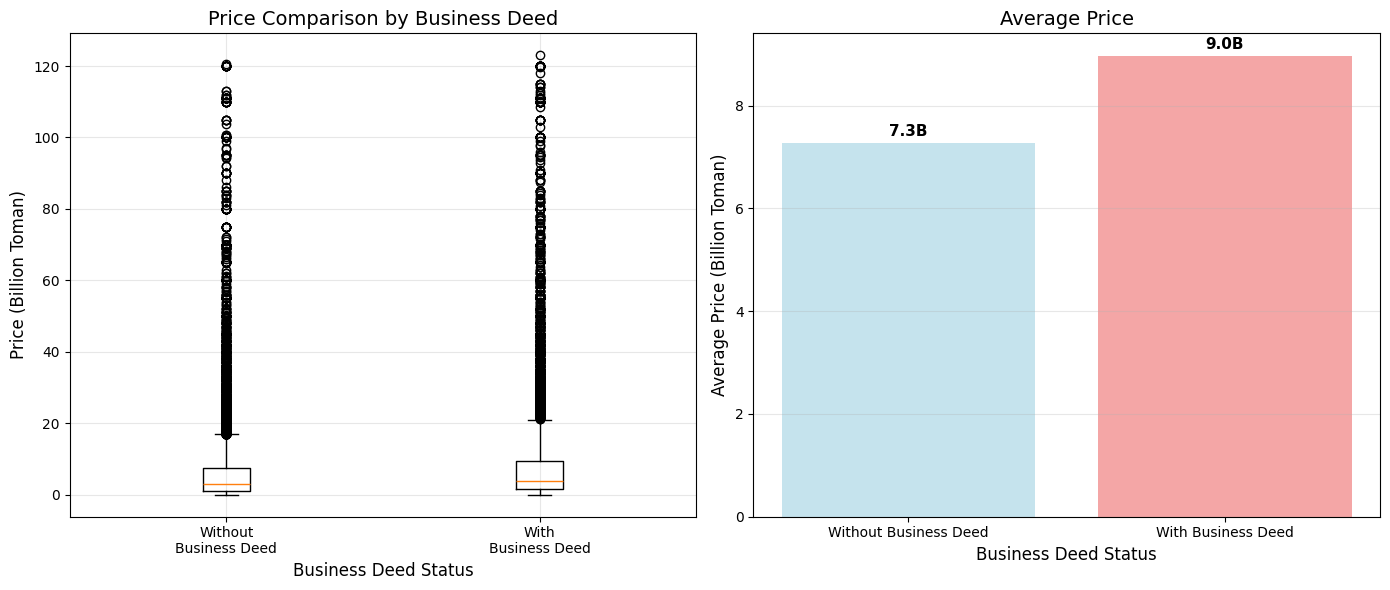

In [81]:
# Simple visualization for Test 3
if 'with_deed' in locals() and 'without_deed' in locals() and len(with_deed) > 30 and len(without_deed) > 30:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Simple comparison (convert to billions for readability)
    with_deed_billions = with_deed / 1e9
    without_deed_billions = without_deed / 1e9
    
    # Box plot
    ax1.boxplot([without_deed_billions, with_deed_billions], 
                labels=['Without\nBusiness Deed', 'With\nBusiness Deed'])
    ax1.set_title('Price Comparison by Business Deed', fontsize=14)
    ax1.set_ylabel('Price (Billion Toman)', fontsize=12)
    ax1.set_xlabel('Business Deed Status', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Average comparison
    avgs = [without_deed.mean()/1e9, with_deed.mean()/1e9]
    types = ['Without Business Deed', 'With Business Deed']
    colors = ['lightblue', 'lightcoral']
    
    bars = ax2.bar(types, avgs, color=colors, alpha=0.7)
    ax2.set_title('Average Price', fontsize=14)
    ax2.set_ylabel('Average Price (Billion Toman)', fontsize=12)
    ax2.set_xlabel('Business Deed Status', fontsize=12)
    
    # Add values on bars
    for bar, avg in zip(bars, avgs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{avg:.1f}B', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for business deed visualization")

<div dir="rtl">

# فرضیه چهارم: تأثیر امکانات لاکچری و غیرلاکچری بر قیمت

**فرضیه اول:**
- **H₀**: میانگین قیمت املاک با امکانات لاکچری برابر با میانگین قیمت املاک بدون امکانات لاکچری است
- **H₁**: میانگین قیمت املاک با امکانات لاکچری بیشتر از میانگین قیمت املاک بدون امکانات لاکچری است

**فرضیه دوم:**
- **H₀**: میانگین قیمت املاک با امکانات غیرلاکچری برابر با میانگین قیمت املاک بدون امکانات غیرلاکچری است
- **H₁**: میانگین قیمت املاک با امکانات غیرلاکچری بیشتر از میانگین قیمت املاک بدون امکانات غیرلاکچری است

**امکانات لاکچری**: استخر، جکوزی، سونا، باربیکیو

**امکانات غیرلاکچری**: بالکن، آسانسور، پارکینگ، نگهبان

</div>

In [82]:
# TEST 4: Do luxury amenities increase prices?
print("=" * 50)
print("TEST 4: LUXURY AMENITIES EFFECT ON PRICES")
print("=" * 50)

# Check what amenity columns we have
print("Looking for amenity columns...")
amenity_cols = [col for col in df.columns if 'has_' in col.lower()]
print(f"Found amenity columns: {amenity_cols}")

# Define luxury and basic amenities based on available columns
luxury_amenities = ['has_pool', 'has_jacuzzi', 'has_sauna', 'has_barbecue']
basic_amenities = ['has_balcony', 'has_elevator', 'has_warehouse', 'has_parking']

available_luxury = [col for col in luxury_amenities if col in df.columns]
available_basic = [col for col in basic_amenities if col in df.columns]

print(f"Available luxury amenities: {available_luxury}")
print(f"Available basic amenities: {available_basic}")

# Get properties with price info
amenity_data = df[
    (df['price_value'].notna()) &
    (df['price_value'] > 0)
].copy()

print(f"Properties with prices: {len(amenity_data)}")

if len(amenity_data) > 0 and len(available_luxury) > 0:
    # Convert amenity columns to boolean
    def has_amenity(value):
        if pd.isna(value):
            return False
        str_val = str(value).lower()
        return str_val in ['true', '1', 'yes', 'دارد', 'True']
    
    # Process luxury amenities
    for col in available_luxury:
        amenity_data[f'{col}_bool'] = amenity_data[col].apply(has_amenity)
    
    # Count luxury amenities
    luxury_cols_bool = [f'{col}_bool' for col in available_luxury]
    amenity_data['luxury_count'] = amenity_data[luxury_cols_bool].sum(axis=1)
    amenity_data['has_luxury'] = amenity_data['luxury_count'] > 0
    
    print(f"Properties with luxury amenities: {amenity_data['has_luxury'].value_counts()}")
    
    # Split by luxury amenities
    with_luxury = amenity_data[amenity_data['has_luxury'] == True]['price_value']
    without_luxury = amenity_data[amenity_data['has_luxury'] == False]['price_value']
    
    print(f"With luxury amenities: {len(with_luxury)} properties")
    print(f"Without luxury amenities: {len(without_luxury)} properties")
    
    if len(with_luxury) > 30 and len(without_luxury) > 30:
        # Basic stats
        print(f"With luxury - Average price: {with_luxury.mean():,.0f} Toman")
        print(f"Without luxury - Average price: {without_luxury.mean():,.0f} Toman")
        
        # Price difference
        diff_percent = ((with_luxury.mean() - without_luxury.mean()) / without_luxury.mean()) * 100
        print(f"Price difference: {diff_percent:.1f}%")
        
        # Statistical test
        _, p_with_lux = normaltest(with_luxury.dropna())
        _, p_without_lux = normaltest(without_luxury.dropna())
        
        if p_with_lux > 0.05 and p_without_lux > 0.05:
            stat, p_val = ttest_ind(with_luxury, without_luxury, alternative='greater')
            test_used = "t-test"
        else:
            stat, p_val = mannwhitneyu(with_luxury, without_luxury, alternative='greater')
            test_used = "Mann-Whitney U test"
        
        print(f"Test used: {test_used}")
        print(f"P-value: {p_val:.6f}")
        
        if p_val < 0.05:
            print("RESULT: YES - Luxury amenities increase prices")
        else:
            print("RESULT: NO - Luxury amenities don't affect prices")
    else:
        print("Not enough data for luxury amenities test")
else:
    print("No luxury amenity data available")

# TEST 4B: Basic amenities
print("\n" + "=" * 30)
print("BASIC AMENITIES EFFECT")
print("=" * 30)

if len(amenity_data) > 0 and len(available_basic) > 0:
    # Process basic amenities
    for col in available_basic:
        if col in amenity_data.columns:
            amenity_data[f'{col}_bool'] = amenity_data[col].apply(has_amenity)
    
    # Count basic amenities
    basic_cols_bool = [f'{col}_bool' for col in available_basic if col in amenity_data.columns]
    if basic_cols_bool:
        amenity_data['basic_count'] = amenity_data[basic_cols_bool].sum(axis=1)
        amenity_data['has_basic'] = amenity_data['basic_count'] > 0
        
        print(f"Properties with basic amenities: {amenity_data['has_basic'].value_counts()}")
        
        with_basic = amenity_data[amenity_data['has_basic'] == True]['price_value']
        without_basic = amenity_data[amenity_data['has_basic'] == False]['price_value']
        
        if len(with_basic) > 30 and len(without_basic) > 30:
            print(f"With basic - Average price: {with_basic.mean():,.0f} Toman")
            print(f"Without basic - Average price: {without_basic.mean():,.0f} Toman")
            
            diff_percent = ((with_basic.mean() - without_basic.mean()) / without_basic.mean()) * 100
            print(f"Price difference: {diff_percent:.1f}%")
            
            # Statistical test
            _, p_with_basic = normaltest(with_basic.dropna())
            _, p_without_basic = normaltest(without_basic.dropna())
            
            if p_with_basic > 0.05 and p_without_basic > 0.05:
                stat, p_val = ttest_ind(with_basic, without_basic, alternative='greater')
                test_used = "t-test"
            else:
                stat, p_val = mannwhitneyu(with_basic, without_basic, alternative='greater')
                test_used = "Mann-Whitney U test"
            
            print(f"Test used: {test_used}")
            print(f"P-value: {p_val:.6f}")
            
            if p_val < 0.05:
                print("RESULT: YES - Basic amenities increase prices")
            else:
                print("RESULT: NO - Basic amenities don't affect prices")
        else:
            print("Not enough data for basic amenities test")
    else:
        print("No valid basic amenity columns found")
else:
    print("No basic amenity data available")

TEST 4: LUXURY AMENITIES EFFECT ON PRICES
Looking for amenity columns...
Found amenity columns: ['has_business_deed', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'has_water', 'has_warm_water_provider', 'has_electricity', 'has_gas', 'has_heating_system', 'has_cooling_system', 'has_restroom', 'has_security_guard', 'has_barbecue', 'has_pool', 'has_jacuzzi', 'has_sauna']
Available luxury amenities: ['has_pool', 'has_jacuzzi', 'has_sauna', 'has_barbecue']
Available basic amenities: ['has_balcony', 'has_elevator', 'has_warehouse', 'has_parking']
Properties with prices: 557336
Properties with luxury amenities: has_luxury
False    551122
True       6214
Name: count, dtype: int64
With luxury amenities: 6214 properties
Without luxury amenities: 551122 properties
With luxury - Average price: 5,491,333,429 Toman
Without luxury - Average price: 5,788,068,944 Toman
Price difference: -5.1%
Test used: Mann-Whitney U test
P-value: 0.000000
RESULT: YES - Luxury amenities increase pric

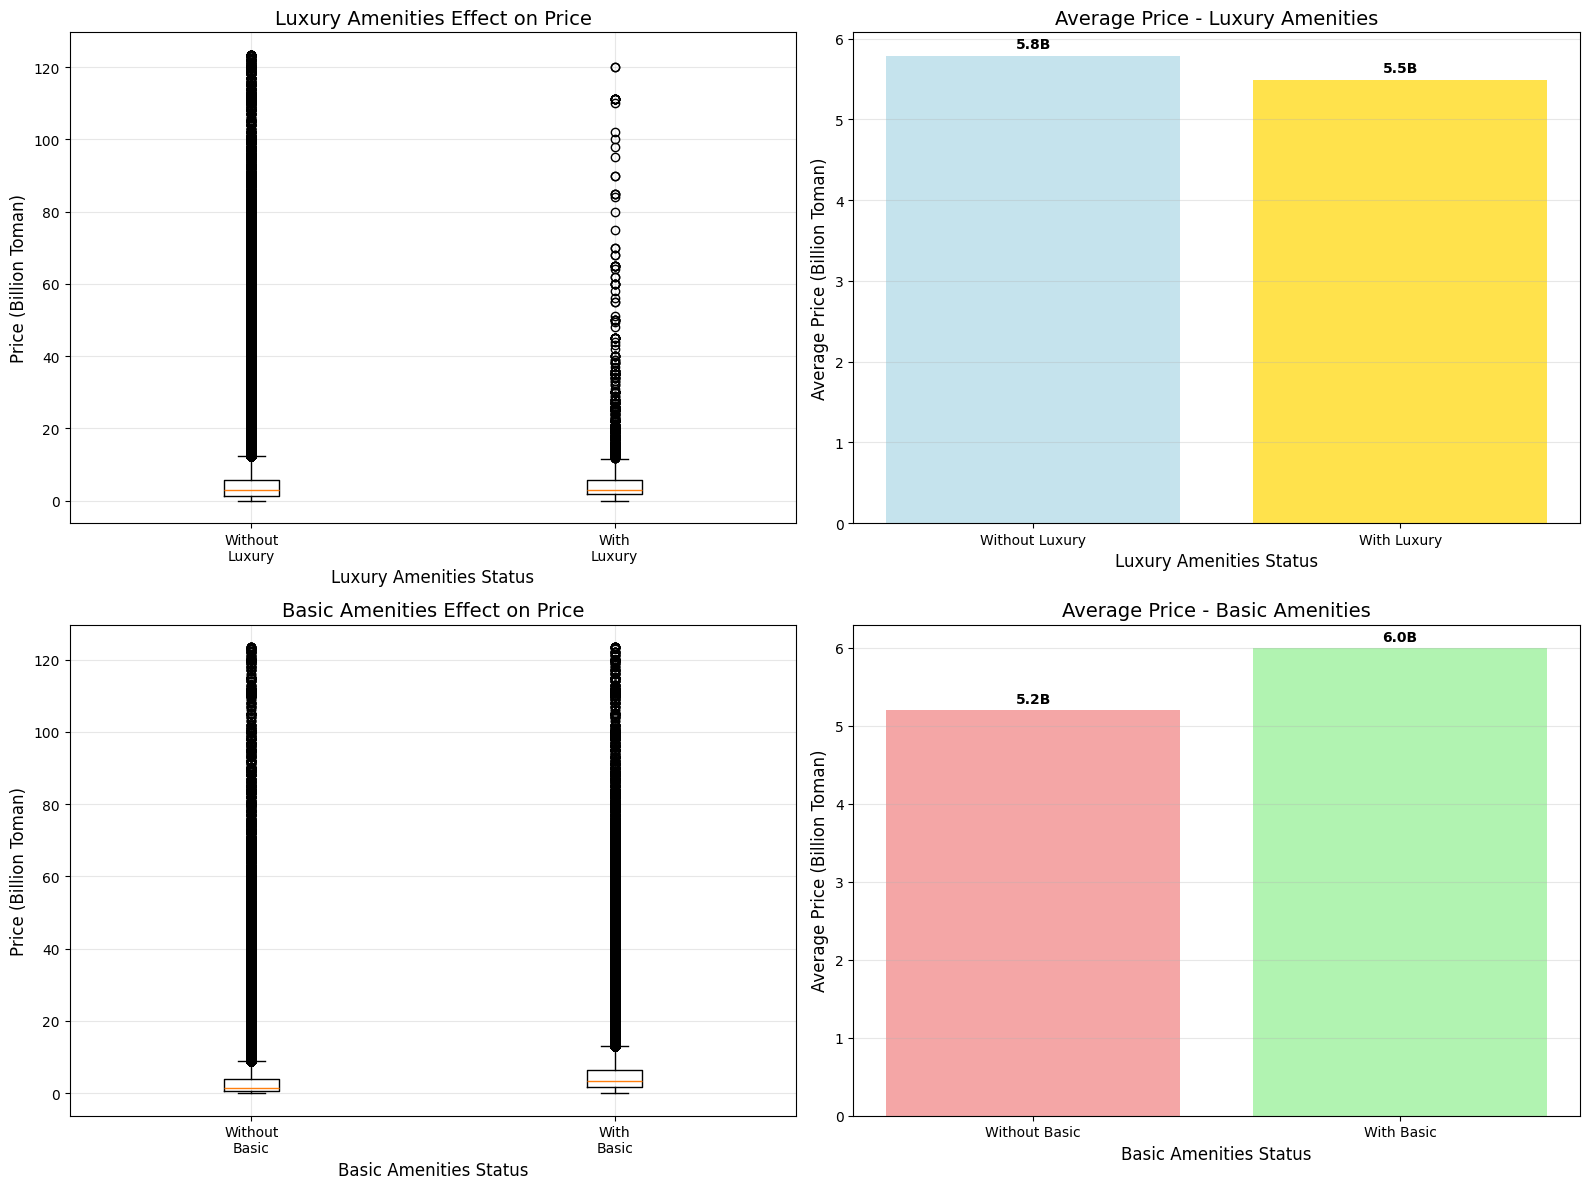

In [83]:
# Simple visualization for Test 4
if ('with_luxury' in locals() and 'without_luxury' in locals() and 
    len(with_luxury) > 30 and len(without_luxury) > 30):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Luxury amenities visualization
    with_lux_billions = with_luxury / 1e9
    without_lux_billions = without_luxury / 1e9
    
    # Box plot for luxury
    axes[0,0].boxplot([without_lux_billions, with_lux_billions], 
                      labels=['Without\nLuxury', 'With\nLuxury'])
    axes[0,0].set_title('Luxury Amenities Effect on Price', fontsize=14)
    axes[0,0].set_ylabel('Price (Billion Toman)', fontsize=12)
    axes[0,0].set_xlabel('Luxury Amenities Status', fontsize=12)
    axes[0,0].grid(True, alpha=0.3)
    
    # Bar chart for luxury
    lux_avgs = [without_luxury.mean()/1e9, with_luxury.mean()/1e9]
    lux_labels = ['Without Luxury', 'With Luxury']
    lux_colors = ['lightblue', 'gold']
    
    bars = axes[0,1].bar(lux_labels, lux_avgs, color=lux_colors, alpha=0.7)
    axes[0,1].set_title('Average Price - Luxury Amenities', fontsize=14)
    axes[0,1].set_ylabel('Average Price (Billion Toman)', fontsize=12)
    axes[0,1].set_xlabel('Luxury Amenities Status', fontsize=12)
    
    for bar, avg in zip(bars, lux_avgs):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{avg:.1f}B', ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3, axis='y')
    
    # Basic amenities if available
    if ('with_basic' in locals() and 'without_basic' in locals() and 
        len(with_basic) > 30 and len(without_basic) > 30):
        
        with_basic_billions = with_basic / 1e9
        without_basic_billions = without_basic / 1e9
        
        # Box plot for basic
        axes[1,0].boxplot([without_basic_billions, with_basic_billions], 
                          labels=['Without\nBasic', 'With\nBasic'])
        axes[1,0].set_title('Basic Amenities Effect on Price', fontsize=14)
        axes[1,0].set_ylabel('Price (Billion Toman)', fontsize=12)
        axes[1,0].set_xlabel('Basic Amenities Status', fontsize=12)
        axes[1,0].grid(True, alpha=0.3)
        
        # Bar chart for basic
        basic_avgs = [without_basic.mean()/1e9, with_basic.mean()/1e9]
        basic_labels = ['Without Basic', 'With Basic']
        basic_colors = ['lightcoral', 'lightgreen']
        
        bars = axes[1,1].bar(basic_labels, basic_avgs, color=basic_colors, alpha=0.7)
        axes[1,1].set_title('Average Price - Basic Amenities', fontsize=14)
        axes[1,1].set_ylabel('Average Price (Billion Toman)', fontsize=12)
        axes[1,1].set_xlabel('Basic Amenities Status', fontsize=12)
        
        for bar, avg in zip(bars, basic_avgs):
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{avg:.1f}B', ha='center', va='bottom', fontsize=10, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1,0].axis('off')
        axes[1,1].axis('off')
        axes[1,0].text(0.5, 0.5, 'Not enough data for basic amenities', 
                       ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for amenities visualization")

<div dir="rtl">

# خلاصه نتایج آزمون‌های فرض

در این بخش خلاصه‌ای از تمام نتایج آزمون‌های فرض ارائه می‌دهیم.

</div>

In [84]:
# SUMMARY OF ALL TESTS
print("=" * 60)
print("SUMMARY OF HYPOTHESIS TESTING RESULTS")
print("=" * 60)

# Initialize result variables
test1_result = "Unable to test (insufficient data)"
test2_result = "Unable to test (insufficient data)"  
test3_result = "Unable to test (insufficient data)"
test4_luxury_result = "Unable to test (insufficient data)"
test4_basic_result = "Unable to test (insufficient data)"

print("Test 1: Big cities vs small cities house size")
print("Question: Do big cities have smaller houses?")
# Check if test 1 variables exist and have data
try:
    if 'big_city_sizes' in globals() and 'small_city_sizes' in globals() and len(big_city_sizes) > 30:
        avg_big = big_city_sizes.mean()
        avg_small = small_city_sizes.mean()
        print(f"Big cities average: {avg_big:.1f} sqm")
        print(f"Small cities average: {avg_small:.1f} sqm")
        test1_result = "YES - Big cities have smaller houses" if avg_big < avg_small else "NO - Big cities don't have smaller houses"
    print(f"ANSWER: {test1_result}")
except:
    print(f"ANSWER: {test1_result}")
print()

print("Test 2: Old vs new buildings size")
print("Question: Are old buildings bigger than new ones?")
print("This tests the saying: 'قدیما خونه‌ها دلبازتر بود'")
# Check if test 2 variables exist and have data
try:
    if 'old_buildings' in globals() and 'new_buildings' in globals() and len(old_buildings) > 30:
        avg_old = old_buildings.mean()
        avg_new = new_buildings.mean()
        print(f"Old buildings average: {avg_old:.1f} sqm")
        print(f"New buildings average: {avg_new:.1f} sqm")
        test2_result = "YES - Old buildings are bigger" if avg_old > avg_new else "NO - Old buildings are not bigger"
    print(f"ANSWER: {test2_result}")
except:
    print(f"ANSWER: {test2_result}")
print()

print("Test 3: Business deed effect on prices")
print("Question: Do business deeds increase property prices?")
try:
    if 'with_deed' in globals() and 'without_deed' in globals() and len(with_deed) > 30:
        avg_with = with_deed.mean()
        avg_without = without_deed.mean()
        print(f"With deed average: {avg_with:,.0f} Toman")
        print(f"Without deed average: {avg_without:,.0f} Toman")
        diff_percent = ((avg_with - avg_without) / avg_without) * 100
        print(f"Price difference: {diff_percent:.1f}%")
        test3_result = "YES - Business deeds increase prices" if avg_with > avg_without else "NO - Business deeds don't increase prices"
    print(f"ANSWER: {test3_result}")
except:
    print(f"ANSWER: {test3_result}")
print()

print("Test 4: Amenities effect on prices")
print("Question: Do luxury and basic amenities increase prices?")
print("- Luxury: pool, jacuzzi, sauna, barbecue")
print("- Basic: balcony, elevator, parking, warehouse")

# Luxury amenities result
try:
    if 'with_luxury' in globals() and 'without_luxury' in globals() and len(with_luxury) > 30:
        avg_lux_with = with_luxury.mean()
        avg_lux_without = without_luxury.mean()
        print(f"With luxury average: {avg_lux_with:,.0f} Toman")
        print(f"Without luxury average: {avg_lux_without:,.0f} Toman")
        test4_luxury_result = "YES - Luxury amenities increase prices" if avg_lux_with > avg_lux_without else "NO - Luxury amenities don't increase prices"
    print(f"LUXURY ANSWER: {test4_luxury_result}")
except:
    print(f"LUXURY ANSWER: {test4_luxury_result}")

# Basic amenities result
try:
    if 'with_basic' in globals() and 'without_basic' in globals() and len(with_basic) > 30:
        avg_basic_with = with_basic.mean()
        avg_basic_without = without_basic.mean()
        print(f"With basic average: {avg_basic_with:,.0f} Toman")
        print(f"Without basic average: {avg_basic_without:,.0f} Toman")
        test4_basic_result = "YES - Basic amenities increase prices" if avg_basic_with > avg_basic_without else "NO - Basic amenities don't increase prices"
    print(f"BASIC ANSWER: {test4_basic_result}")
except:
    print(f"BASIC ANSWER: {test4_basic_result}")
print()

print("=" * 60)
print("FINAL SUMMARY:")
print("=" * 60)
print(f"1. Big cities vs small cities: {test1_result}")
print(f"2. Old vs new buildings: {test2_result}")
print(f"3. Business deed effect: {test3_result}")
print(f"4a. Luxury amenities effect: {test4_luxury_result}")
print(f"4b. Basic amenities effect: {test4_basic_result}")

print()
print("=" * 60)
print("HOW TO READ RESULTS:")
print("=" * 60)
print("P-value < 0.05: YES - There is a significant difference")
print("P-value >= 0.05: NO - No significant difference")
print()
print("Statistical tests used:")
print("- Normal data: t-test")
print("- Non-normal data: Mann-Whitney U test")
print("=" * 60)

SUMMARY OF HYPOTHESIS TESTING RESULTS
Test 1: Big cities vs small cities house size
Question: Do big cities have smaller houses?
Big cities average: 226.0 sqm
Small cities average: 391.2 sqm
ANSWER: YES - Big cities have smaller houses

Test 2: Old vs new buildings size
Question: Are old buildings bigger than new ones?
This tests the saying: 'قدیما خونه‌ها دلبازتر بود'
ANSWER: Unable to test (insufficient data)

Test 3: Business deed effect on prices
Question: Do business deeds increase property prices?
With deed average: 8,960,580,202 Toman
Without deed average: 7,275,314,653 Toman
Price difference: 23.2%
ANSWER: YES - Business deeds increase prices

Test 4: Amenities effect on prices
Question: Do luxury and basic amenities increase prices?
- Luxury: pool, jacuzzi, sauna, barbecue
- Basic: balcony, elevator, parking, warehouse
With luxury average: 5,491,333,429 Toman
Without luxury average: 5,788,068,944 Toman
LUXURY ANSWER: NO - Luxury amenities don't increase prices
With basic avera